## Import packages

In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.stats as sc
import metpy as mtp
import math
from scipy import integrate
import ERA5_functions as era_fncts
import pandas as pd

from matplotlib.pyplot import cm
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

%load_ext autoreload
%autoreload 2

### Constants

In [2]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [3]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

### Load instantaneous AHT calcs

In [4]:
aht_ds = xr.open_dataset('aht_time_series/era5_aht_time_series.nc')

### Load local AHT data

In [5]:
ddir = 'aht_time_series/one_lat/eddy_total_'
local_aht_dict = {}

lats_subset = [35, 40, 45, 50, 55, 60, 65, 70]
for lat in lats_subset:
    eddy_data = []
    eddy_files = sorted(glob(ddir + str(lat) + '*'))
    for file in eddy_files:
        file_data = np.load(file)
        eddy_data.append(file_data)

    eddy_local = np.concatenate(eddy_data)
    local_aht_dict[lat] = eddy_local

In [6]:
def get_stat(lat, stat):
    ''' Function to pull summary stats for each longitude from the local_aht_dict
    '''
    
    local_aht_values = local_aht_dict[lat]
    
    if stat == 'mean':
        summary_stat = np.mean(local_aht_values, axis=0)
        
    elif stat == 'std':
        summary_stat = np.std(local_aht_values, axis=0)
    
    elif stat == 'skew':
        summary_stat = sc.skew(local_aht_values, axis=0)
        
    elif stat == 'kurtosis':
        summary_stat = sc.kurtosis(local_aht_values, axis=0)
        
    else:
        print('Summary stat not recognized')
        
    return summary_stat

In [7]:
means = np.zeros((len(lats_subset), 720))
stds = np.zeros((len(lats_subset), 720))
skews = np.zeros((len(lats_subset), 720))
kurtoses = np.zeros((len(lats_subset), 720))

for idx, lat in enumerate(lats_subset):
    means[idx,:] = get_stat(lat, 'mean')
    stds[idx,:] = get_stat(lat, 'std')
    skews[idx,:] = get_stat(lat, 'skew')
    kurtoses[idx,:] = get_stat(lat, 'kurtosis')
    

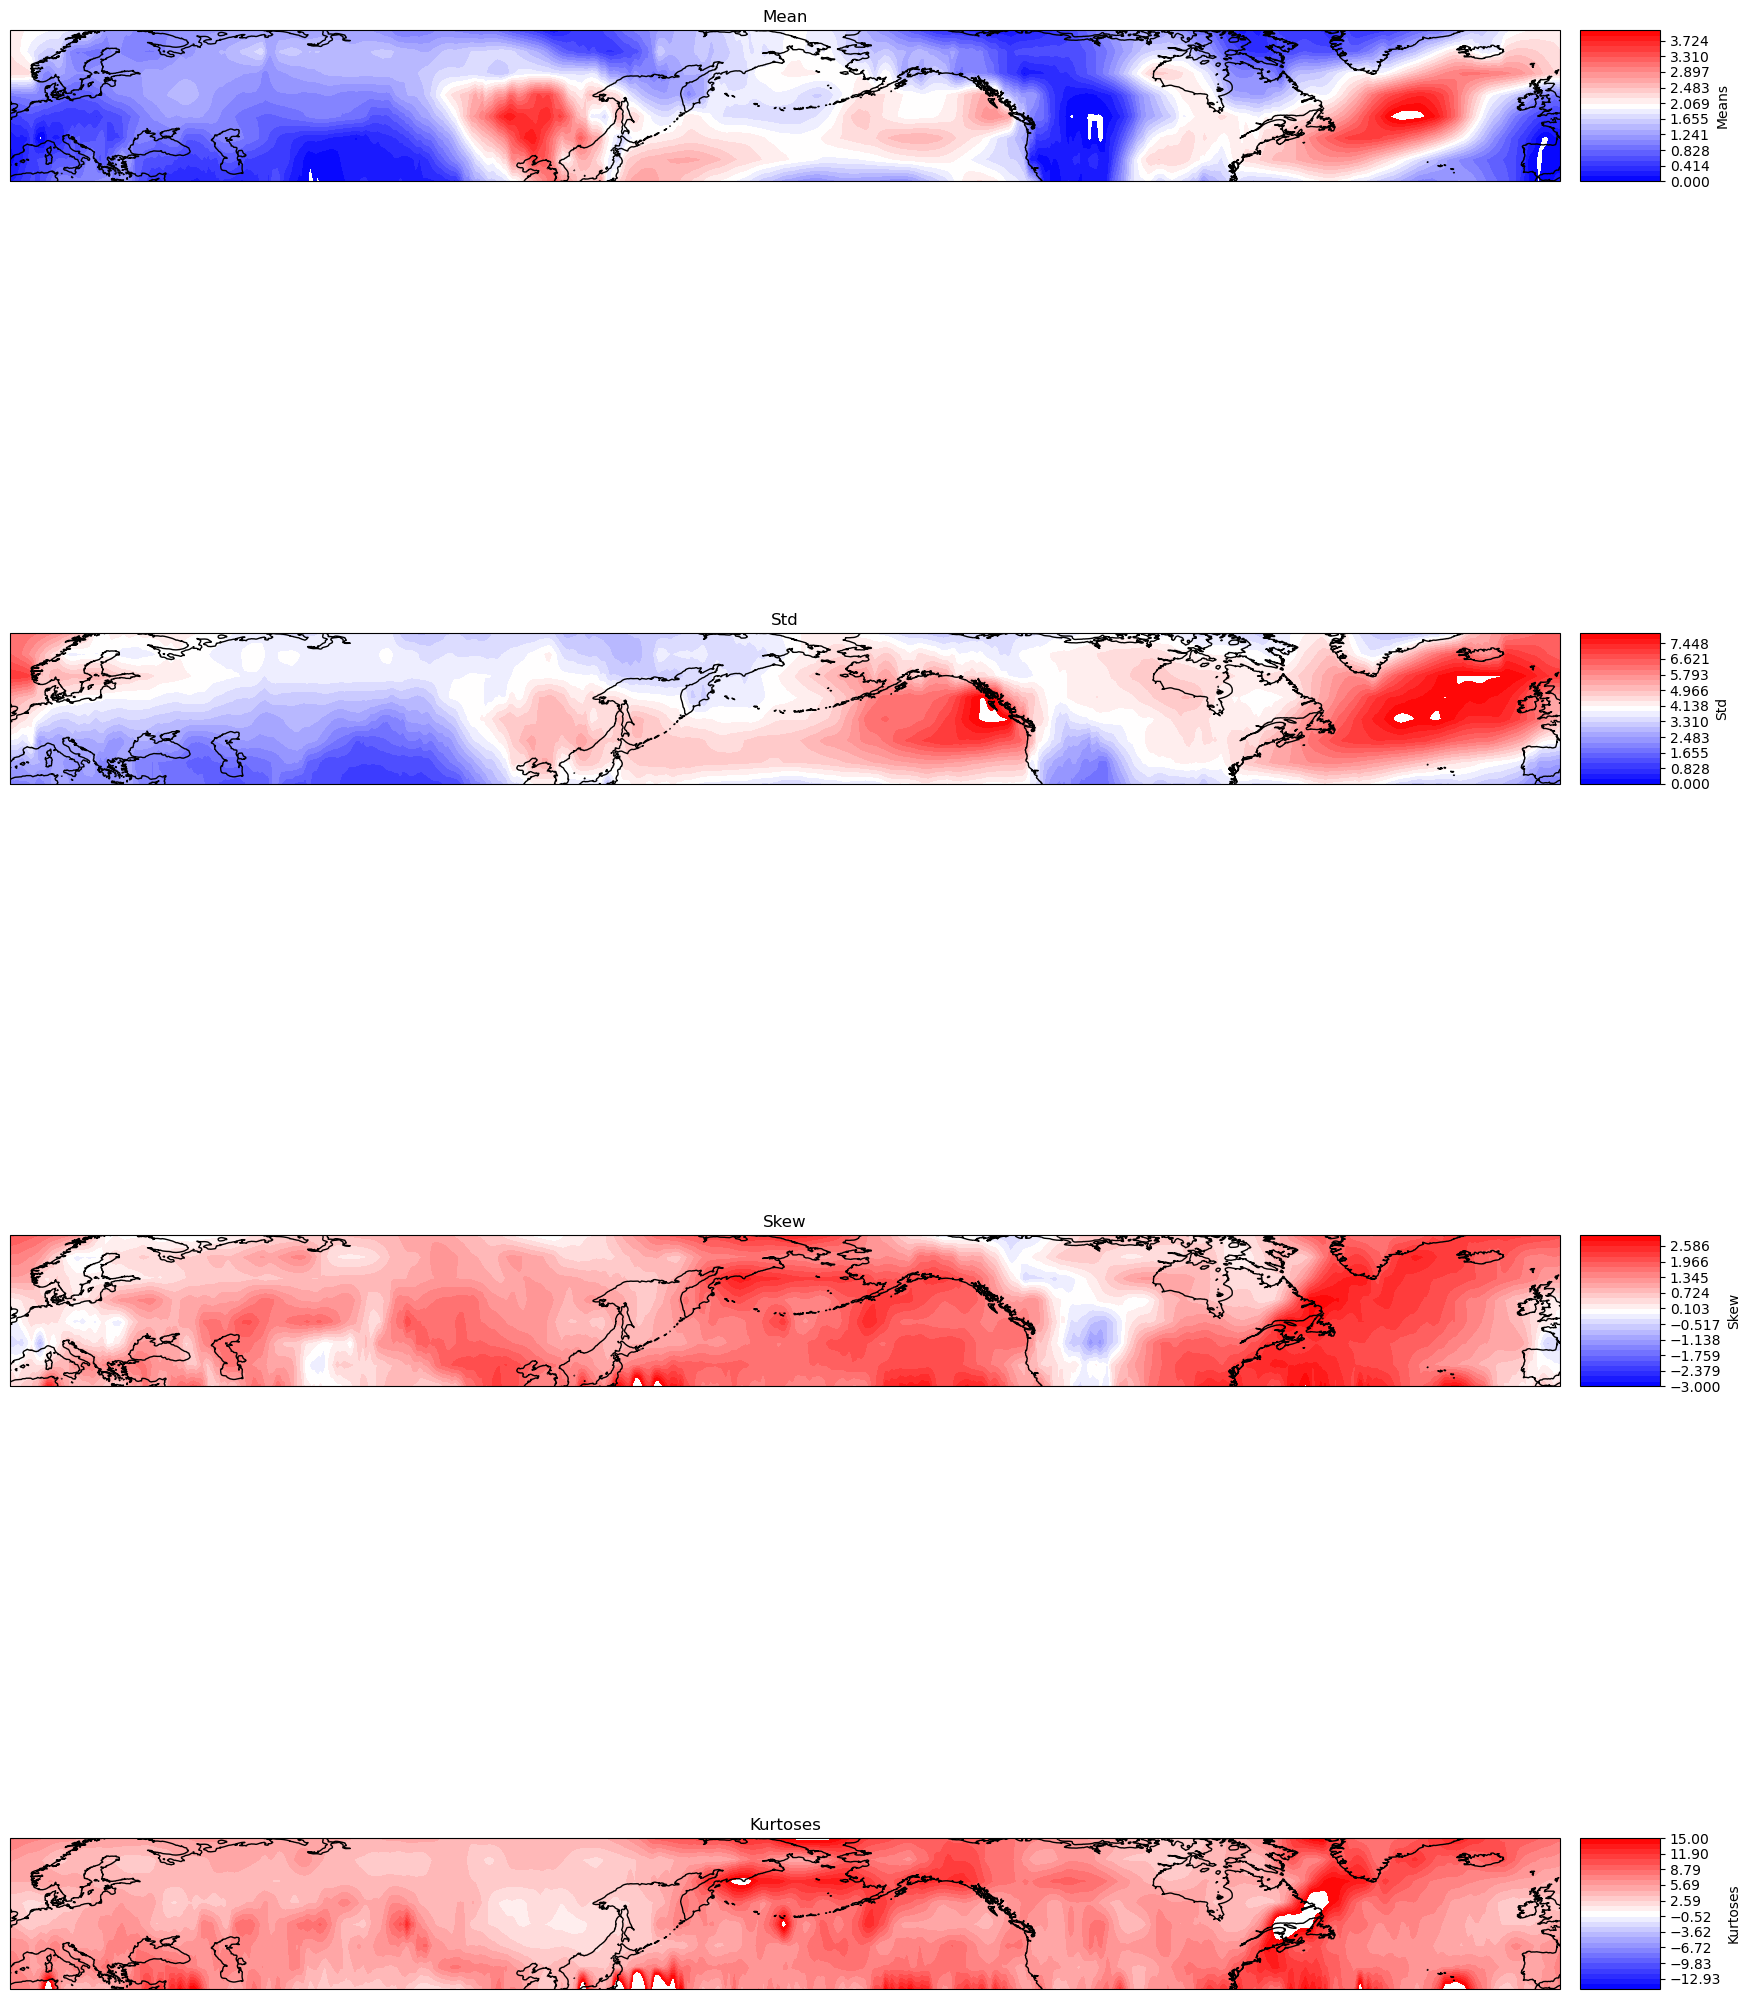

In [8]:
fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(20,30), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

axs[0].coastlines()
contf = axs[0].contourf(lons, lats_subset, means / 1e9, levels=np.linspace(0, 4, 30),
                    cmap='bwr', transform=ccrs.PlateCarree())
#get size and extent of axes:
axpos = axs[0].get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.04
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(contf, cax=pos_cax, label='Means')
axs[0].set_title('Mean')

axs[1].coastlines()
contf = axs[1].contourf(lons, lats_subset, stds / 1e9, levels=np.linspace(0, 8, 30),
                    cmap='bwr', transform=ccrs.PlateCarree())
#get size and extent of axes:
axpos = axs[1].get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.04
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(contf, cax=pos_cax, label='Std')
axs[1].set_title('Std')

axs[2].coastlines()
contf = axs[2].contourf(lons, lats_subset, skews, levels=np.linspace(-3, 3, 30),
                    cmap='bwr', transform=ccrs.PlateCarree())
#get size and extent of axes:
axpos = axs[2].get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.04
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(contf, cax=pos_cax, label='Skew')
axs[2].set_title('Skew')

axs[3].coastlines()
contf = axs[3].contourf(lons, lats_subset, kurtoses, levels=np.linspace(-15, 15, 30),
                    cmap='bwr', transform=ccrs.PlateCarree())
#get size and extent of axes:
axpos = axs[3].get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.04
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(contf, cax=pos_cax, label='Kurtoses')
axs[3].set_title('Kurtoses')

#plt.savefig('figures/3_15_22_meeting/local_eddy_aht_stats')
plt.show()

### See if AHT distributions are different in areas of cold air outbreaks versus not

### First lets get oriented on a map to decide which regions to choose

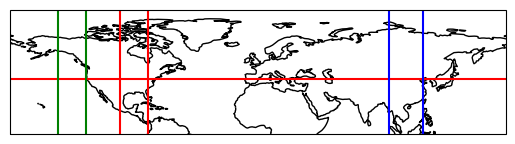

In [9]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

ax.set_ylim([0, 90])
ax.set_xlim([-180, 180])

plt.axhline(40, color='r')

plt.axvline(lons[190], color='b')
plt.axvline(lons[240], color='b')

plt.axvline(lons[430]-360, color='g')
plt.axvline(lons[470]-360, color='g')

plt.axvline(lons[520]-360, color='r')
plt.axvline(lons[560]-360, color='r')

plt.show()

### Make a function that will grab rolling windows for us and see how much of the AHT is done by the top XX% events

In [10]:
def get_extremes_rolling_window(which_lat):
    ddir = 'aht_time_series/one_lat/'
    eddy_files = sorted(glob(ddir + 'eddy_total_' + str(which_lat) +'*'))

    eddy_data = []
    for eddy in eddy_files:
        file_data = np.load(eddy)
        eddy_data.append(file_data)

    eddy_local = np.concatenate(eddy_data)
    
    # Lets loop through each longitude with a 20 deg rolling window
    window_size = 40 #In degrees / 2
    rolling_windows = np.zeros((720, len(eddy_local[:,0]) * 40))
    for i in range(720):
        try:
            #print(np.shape(eddy_local[:,i-20:i+20].flatten()))
            rolling_windows[i,:] = eddy_local[:,i-20:i+20].flatten()
        except:
            #print(i)
            pass
        
    extreme_ratio = np.zeros(720)

    for i in range(720):
        rolling_sorted = np.sort(rolling_windows[i,:])
        rolling_window_top_5_perc = rolling_sorted[int(0.95 * len(rolling_sorted)):]

        extreme_ratio[i] = np.sum(rolling_window_top_5_perc) / np.sum(rolling_sorted)
    
    return extreme_ratio

### Choose some latitudes and run the function

In [11]:
test_lats = [35, 40, 45, 50, 55, 60, 65, 70]

extreme_ratios = np.zeros((len(test_lats), 720))
for i in range(len(test_lats)):
    one_lat = test_lats[i]
    extreme_ratios[i,:] = get_extremes_rolling_window(one_lat)

<ipython-input-10-f5e24f663b8f>:29: RuntimeWarning: invalid value encountered in double_scalars
  extreme_ratio[i] = np.sum(rolling_window_top_5_perc) / np.sum(rolling_sorted)


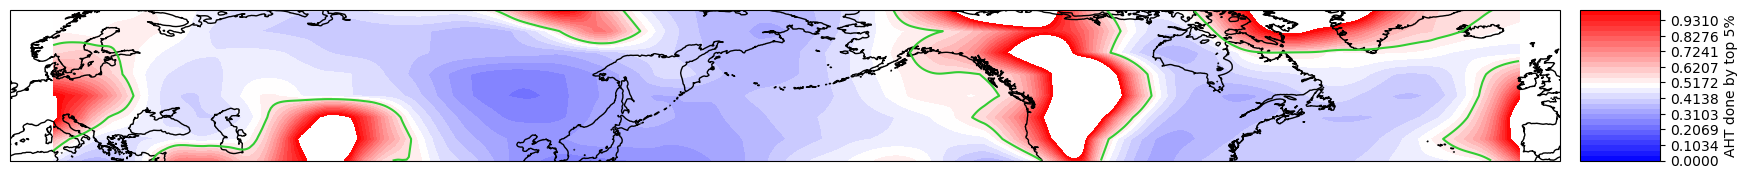

In [12]:
fig=plt.figure(figsize=(20,30))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines()

contf = ax.contourf(lons, test_lats, extreme_ratios, levels=np.linspace(0, 1, 30), cmap='bwr', transform=ccrs.PlateCarree())
ax.contour(lons, test_lats, extreme_ratios, levels=[0.55], colors='limegreen', transform=ccrs.PlateCarree())

#get size and extent of axes:
axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.04
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])


plt.colorbar(contf, cax=pos_cax, label='AHT done by top 5%')

#plt.savefig('figures/3_15_22_meeting/eddy_aht_top_5_perc_local_percent')
plt.show()